Create surrogate neural population responses during natural behavior trials using reduced populations with parameters chosen based on theoretical considerations.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_plot
from my_torch import skl_fit_ridge
from my_stats import nanpearsonr

from record import smlt_ppln_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

ALPHA = 10

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'
PFX_NRL = f'data/simple/mlv/ma_red_distr/temp_nrl/temp_ma_red_ppln'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

Load behavioral data from Coen et al 2014

In [3]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [4]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

In [5]:
# neural response fits from Baker data
df_ma_param = pd.read_csv('data/simple/neur/baker_ma_fit_param.csv')

In [6]:
# function for recording surrogate neural activity and predicting behavior
def record_fit(tau_rs, tau_as, x_ss, x_ps):
    n = len(tau_rs)
    r_cols = [f'R_{cr}' for cr in range(n)]
    
    # record data
    sys.stdout.write('R')
    for itr, df_tr in zip(ISTRAIN, dfs_tr):
        df_tr_nrl = df_tr.copy()

        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)

        # simulate population response
        rs = smlt_ppln_ma(i_s, i_p, tau_rs, tau_as, x_ss, x_ps, DT)

        df_tr_nrl[r_cols] = rs

        np.save(f'{PFX_NRL}_tr_{itr}.npy', np.array([{'df': df_tr_nrl}]))
        
    sys.stdout.write('F')
    # fit neural -> behav regression model
    rslts = skl_fit_ridge(
        pfxs=[PFX_NRL, PFX_BHV],
        cols_x=r_cols,
        targs=TARGS,
        itr_all=ISTRAIN,
        ntrain=NTRAIN,
        nsplit=NSPLIT,
        alpha=ALPHA,
        verbose=False)
    r2_train_mns = {targ: np.mean([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS}
    r2_test_mns = {targ: np.mean([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS}
    
    r2_train_sds = {targ: np.std([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS}
    r2_test_sds = {targ: np.std([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS}
    
    sys.stdout.write('..')
    
    return r2_train_mns, r2_test_mns, r2_train_sds, r2_test_sds

# Test using full population

# Sweep over mean response and adaptation rates given uniformly distributed selectivities

Exponentially distributed $\tau_r$ and $1/\tau_a$. Uniform $x_s$, $x_p$ (given $x_s + x_p = 1$).

### 10 neurons

In [7]:
n = 10
fname = f'0A_{n}_nrn_unif_sel_sweep_mean_tau_r_tau_a'
mn_tau_rs = [.1, .5, 1, 2, 5, 10, 30, 60, 120]
mn_rate_as = [10, 5, 2, 1, .5, .1, .05, .01]

r2_test_mn_all = {targ: np.nan*np.zeros((len(mn_tau_rs), len(mn_rate_as))) for targ in TARGS}

for cmn_tau_r, mn_tau_r in enumerate(mn_tau_rs):
    for cmn_rate_a, mn_rate_a in enumerate(mn_rate_as):
        np.random.seed(None)
        tau_rs = np.clip(np.random.exponential(mn_tau_r, n), .065, np.inf)  # ensure no numerical issues from tau < dt
        tau_as = np.clip(1/np.random.exponential(mn_rate_a, n), 0.065, np.inf)
        x_ss = np.random.uniform(0, 1, n)
        x_ps = 1 - x_ss

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][cmn_tau_r, cmn_rate_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red_distr/{fname}.npy', np.array([{
    'mn_tau_rs': mn_tau_rs,
    'mn_rate_as': mn_rate_as,
    'r2_test_mn_all': r2_test_mn_all
}]))

RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..

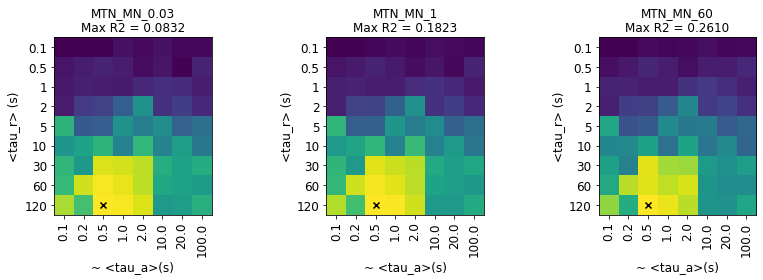

In [10]:
rslts = np.load(f'data/simple/mlv/ma_red_distr/0A_10_nrn_unif_sel_sweep_mean_tau_r_tau_a.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['mn_rate_as'])),
        y_ticks=np.arange(len(rslts['mn_tau_rs'])),
        y_tick_labels=rslts['mn_tau_rs'],
        x_label='~ <tau_a>(s)',
        y_label='<tau_r> (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(1/np.array(rslts['mn_rate_as']), rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

### 25 neurons

In [ ]:
n = 25
fname = f'0B_{n}_nrn_unif_sel_sweep_mean_tau_r_tau_a'
mn_tau_rs = [.1, .5, 1, 2, 5, 10, 30, 60, 120]
mn_rate_as = [10, 5, 2, 1, .5, .1, .05, .01]

r2_test_mn_all = {targ: np.nan*np.zeros((len(mn_tau_rs), len(mn_rate_as))) for targ in TARGS}

for cmn_tau_r, mn_tau_r in enumerate(mn_tau_rs):
    for cmn_rate_a, mn_rate_a in enumerate(mn_rate_as):
        np.random.seed(None)
        tau_rs = np.clip(np.random.exponential(mn_tau_r, n), .065, np.inf)  # ensure no numerical issues from tau < dt
        tau_as = np.clip(1/np.random.exponential(mn_rate_a, n), 0.065, np.inf)
        x_ss = np.random.uniform(0, 1, n)
        x_ps = 1 - x_ss

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][cmn_tau_r, cmn_rate_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red_distr/{fname}.npy', np.array([{
    'mn_tau_rs': mn_tau_rs,
    'mn_rate_as': mn_rate_as,
    'r2_test_mn_all': r2_test_mn_all
}]))

RF..RF..RF

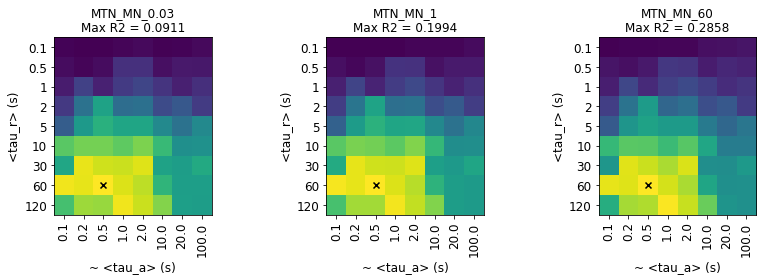

In [11]:
rslts = np.load(f'data/simple/mlv/ma_red_distr/0B_25_nrn_unif_sel_sweep_mean_tau_r_tau_a.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['mn_rate_as'])),
        y_ticks=np.arange(len(rslts['mn_tau_rs'])),
        y_tick_labels=rslts['mn_tau_rs'],
        x_label='~ <tau_a> (s)',
        y_label='<tau_r> (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(1/np.array(rslts['mn_rate_as']), rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

### 50 neurons

In [ ]:
n = 50
fname = f'0C_{n}_nrn_unif_sel_sweep_mean_tau_r_tau_a'
mn_tau_rs = [.1, .5, 1, 2, 5, 10, 30, 60, 120]
mn_rate_as = [10, 5, 2, 1, .5, .1, .05, .01]

r2_test_mn_all = {targ: np.nan*np.zeros((len(mn_tau_rs), len(mn_rate_as))) for targ in TARGS}

for cmn_tau_r, mn_tau_r in enumerate(mn_tau_rs):
    for cmn_rate_a, mn_rate_a in enumerate(mn_rate_as):
        np.random.seed(None)
        tau_rs = np.clip(np.random.exponential(mn_tau_r, n), .065, np.inf)  # ensure no numerical issues from tau < dt
        tau_as = np.clip(1/np.random.exponential(mn_rate_a, n), 0.065, np.inf)
        x_ss = np.random.uniform(0, 1, n)
        x_ps = 1 - x_ss

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][cmn_tau_r, cmn_rate_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red_distr/{fname}.npy', np.array([{
    'mn_tau_rs': mn_tau_rs,
    'mn_rate_as': mn_rate_as,
    'r2_test_mn_all': r2_test_mn_all
}]))

RF..RF..RF

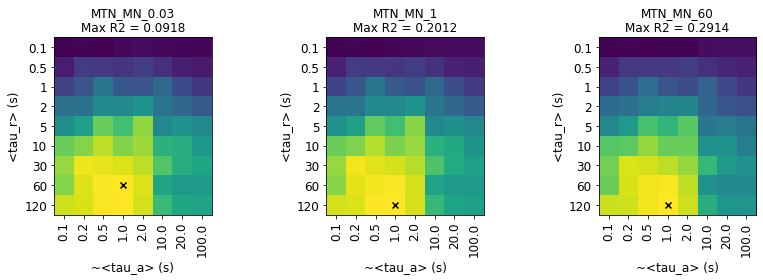

In [7]:
rslts = np.load(f'data/simple/mlv/ma_red_distr/0C_50_nrn_unif_sel_sweep_mean_tau_r_tau_a.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['mn_rate_as'])),
        y_ticks=np.arange(len(rslts['mn_tau_rs'])),
        y_tick_labels=rslts['mn_tau_rs'],
        x_label='~<tau_a> (s)',
        y_label='<tau_r> (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(1/np.array(rslts['mn_rate_as']), rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

### 100 neurons

In [7]:
n = 100
fname = f'0D_{n}_nrn_unif_sel_sweep_mean_tau_r_tau_a'
mn_tau_rs = [.1, .5, 1, 2, 5, 10, 30, 60, 120]
mn_rate_as = [10, 5, 2, 1, .5, .1, .05, .01]

r2_test_mn_all = {targ: np.nan*np.zeros((len(mn_tau_rs), len(mn_rate_as))) for targ in TARGS}

for cmn_tau_r, mn_tau_r in enumerate(mn_tau_rs):
    for cmn_rate_a, mn_rate_a in enumerate(mn_rate_as):
        np.random.seed(None)
        tau_rs = np.clip(np.random.exponential(mn_tau_r, n), .065, np.inf)  # ensure no numerical issues from tau < dt
        tau_as = np.clip(1/np.random.exponential(mn_rate_a, n), 0.065, np.inf)
        x_ss = np.random.uniform(0, 1, n)
        x_ps = 1 - x_ss

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][cmn_tau_r, cmn_rate_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red_distr/{fname}.npy', np.array([{
    'mn_tau_rs': mn_tau_rs,
    'mn_rate_as': mn_rate_as,
    'r2_test_mn_all': r2_test_mn_all
}]))

RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..

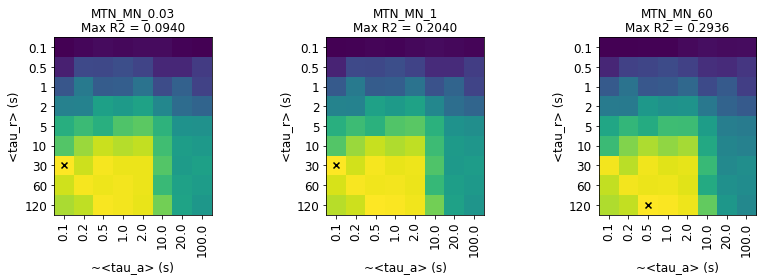

In [8]:
rslts = np.load(f'data/simple/mlv/ma_red_distr/0D_100_nrn_unif_sel_sweep_mean_tau_r_tau_a.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['mn_rate_as'])),
        y_ticks=np.arange(len(rslts['mn_tau_rs'])),
        y_tick_labels=rslts['mn_tau_rs'],
        x_label='~<tau_a> (s)',
        y_label='<tau_r> (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(1/np.array(rslts['mn_rate_as']), rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()